In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [2]:
income_df = pd.read_csv('/home/student/IngajiDemo/dataset.csv')

In [3]:
income_df['Household_Head_Occupation'] = income_df.groupby('Household_Head_Highest_Grade_Completed')['Household_Head_Occupation'].transform(lambda x: x.ffill().bfill())

In [4]:
income_df['Total_Number_of_Family_members'] = income_df.groupby('Type_of_Household')['Total_Number_of_Family_members'].transform(lambda x: x.ffill().bfill())

In [5]:
income_df['Toilet_Facilities'] = income_df.groupby('Total_Number_of_Family_members')['Toilet_Facilities'].transform(lambda x: x.ffill().bfill())

In [6]:
income_df['Household_Head_Class_of_Worker'] = income_df.groupby('Household_Head_Occupation')['Household_Head_Class_of_Worker'].transform(lambda x: x.ffill().bfill())

In [8]:
# print(income_df.isna().sum())

In [7]:
income_df.rename(columns={
    'Total_Food_Expenditure': 'total_food_expenditure', 
    'Bread_and_Cereals_Expenditure': 'bread_and_cereals_expenditure',
    'Total_Rice_Expenditure': 'total_rice_expenditure',
    'Meat_Expenditure': 'meat_expenditure',
    'Total_Fish_and__marine_products_Expenditure': 'total_fish_and_marine_products_expenditure',
    'Fruit_Expenditure': 'fruit_expenditure',
    'Vegetables_Expenditure': 'vegetables_expenditure',
    'Restaurant_and_hotels_Expenditure': 'restaurant_and_hotels_expenditure',
    'Alcoholic_Beverages_Expenditure': 'alcoholic_beverages_expenditure',
    'Tobacco_Expenditure': 'tobacco_expenditure',
    'Clothing,_Footwear_and_Other_Wear_Expenditure': 'clothing_footwear_and_other_wear_expenditure',
    'Housing_and_water_Expenditure': 'housing_and_water_expenditure',
    'Medical_Care_Expenditure': 'medical_care_expenditure',
    'Transportation_Expenditure': 'transportation_expenditure',
    'Communication_Expenditure': 'communication_expenditure',
    'Education_Expenditure': 'education_expenditure',
    'Miscellaneous_Goods_and_Services_Expenditure': 'miscellaneous_goods_and_services_expenditure',
    'Special_Occasions_Expenditure': 'special_occasions_expenditure',
    'Main_Source_of_Income': 'main_source_of_income',
    'Household_Head_Highest_Grade_Completed': 'household_head_highest_grade_completed',
    'Household_Head_Occupation': 'household_head_occupation',
    'Tenure_Status': 'tenure_status',
    'Type_of_Building/House': 'type_of_building_house',
    'Type_of_Household': 'type_of_household',
    'Household_Head_Class_of_Worker': 'household_head_class_of_worker',
    'Total_Household_Income': 'total_household_income',
    'Total_Expenditures': 'total_expenditures',
    'Crop_Farming_and_Gardening_expenses': 'crop_farming_and_gardening_expenses'
}, inplace=True)

In [8]:
# Filter for farmers' occupations
farmer_occupations = [
    'Farmers', 'Agricultural laborers', 'Rice farmers', 'Crop Farming and Gardening',
    'Livestock farmers', 'Agricultural technicians', 'Farmhands and laborers', 'Hog raising farmers'
]

In [9]:
farmers_df = income_df[income_df['household_head_occupation'].isin(farmer_occupations)].copy()

In [10]:
expenditure_columns = [
    'bread_and_cereals_expenditure',
    'total_rice_expenditure',
    'meat_expenditure',
    'total_fish_and_marine_products_expenditure',
    'fruit_expenditure',
    'vegetables_expenditure',
    'restaurant_and_hotels_expenditure',
    'alcoholic_beverages_expenditure',
    'tobacco_expenditure',
    'clothing_footwear_and_other_wear_expenditure',
    'housing_and_water_expenditure',
    'medical_care_expenditure',
    'transportation_expenditure',
    'communication_expenditure',
    'education_expenditure',
    'miscellaneous_goods_and_services_expenditure',
    'special_occasions_expenditure',
    'crop_farming_and_gardening_expenses'
]

In [11]:
# Calculate total expenditures and remaining income
farmers_df['total_expenditures'] = farmers_df[expenditure_columns].sum(axis=1)
farmers_df['remaining_income'] = farmers_df['total_household_income'] - farmers_df['total_expenditures']

In [12]:
# Prepare data for DBSCAN
income_data = farmers_df[['remaining_income']].copy()
income_data = income_data[income_data['remaining_income'] > 0]

In [13]:
# Standardize the data
scaler = StandardScaler()
scaled_income = scaler.fit_transform(income_data)

In [14]:
# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
# Assign clustering results back to the original farmers_df, matching by index
farmers_df['dbscan_cluster'] = -1  # Initialize with noise label
farmers_df.loc[income_data.index, 'dbscan_cluster'] = dbscan.fit_predict(scaled_income)
# farmers_df.head(20)

### DBSCAN
The below cell adds a new column dbscan_cluster to farmers_df, initializing all values to -1, which signifies noise (points that do not belong to any cluster).

Identifies the noise points (outliers) by filtering farmers_df to create a DataFrame noise_points that contains only those rows labeled as noise.

In [15]:
noise_points = farmers_df[farmers_df['dbscan_cluster'] == -1]
# noise_points.head()

In [16]:
# Count the number of clusters (excluding noise)
unique_clusters = set(farmers_df['dbscan_cluster'])
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
print(f'Number of clusters: {num_clusters}')

Number of clusters: 2


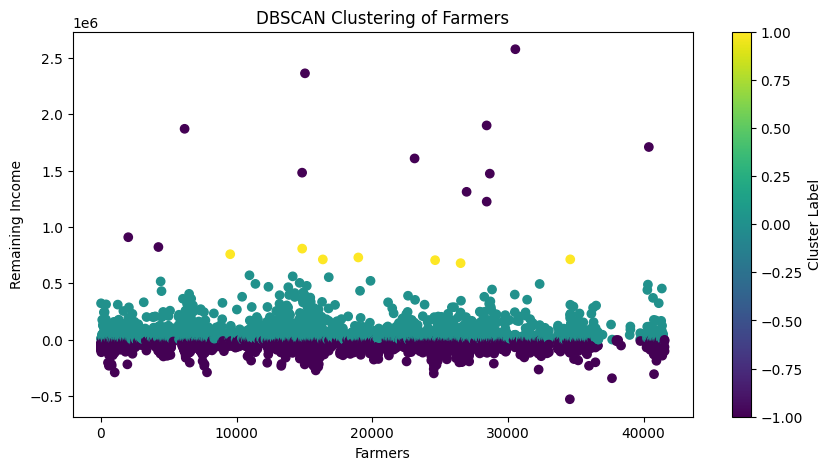

In [17]:
# Visualizing DBSCAN Results
plt.figure(figsize=(10, 5))
plt.scatter(farmers_df.index, farmers_df['remaining_income'], c=farmers_df['dbscan_cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering of Farmers')
plt.xlabel('Farmers')
plt.ylabel('Remaining Income')
plt.colorbar(label='Cluster Label')
plt.show()

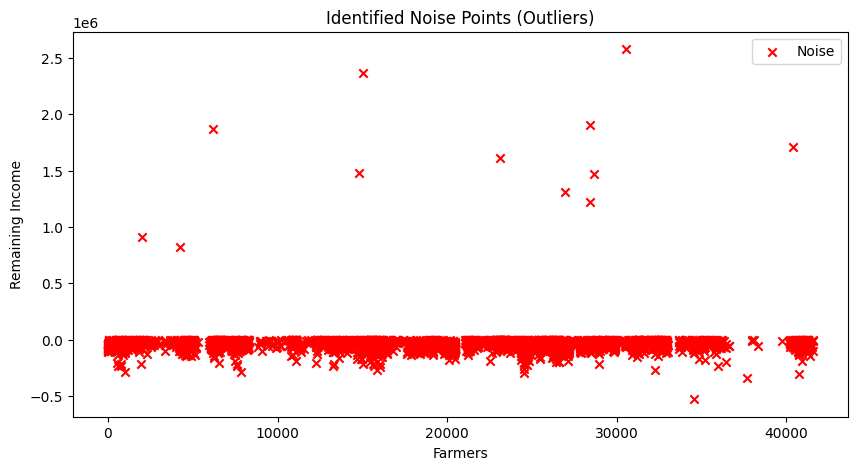

In [22]:
# Optional: Visualizing noise points
if not noise_points.empty:
    plt.figure(figsize=(10, 5))
    plt.scatter(noise_points.index, noise_points['remaining_income'], color='red', label='Noise', marker='x')
    plt.title('Identified Noise Points (Outliers)')
    plt.xlabel('Farmers')
    plt.ylabel('Remaining Income')
    plt.legend()
    plt.show()